<a href="https://colab.research.google.com/github/pthavarasa/Text_Mining_On_Movie_Data/blob/main/Classification_de_texte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 3 : Classification de texte
Le jeu de données fourni pour cet exercice s'appelle "Movie Data". Il
contient 50 000 lignes représentant des avis sur des films et des séries TV.
Chaque ligne se compose de deux colonnes : "review", contenant un avis
écrit en anglais scrappé sur un site spécialisé, et "sentiment", représentant
le label de chaque avis, c'est-à-dire s'il est positif ou négatif. L'objectif de
cet exercice sera alors de développer un modèle de classification de texte.

## 3.1 Téléchargez et installez les packages et leurs dépendances.
* `keras-tcn`: Un package qui fournit l'implémentation TCN (Temporal Convolutional Network) dans Keras.
* `mega.py`: Une bibliothèque Python pour accéder au stockage cloud MEGA.

In [ ]:
!pip install keras-tcn
!pip install mega.py

## 3.2 Importation des bibliothèques et modules nécessaires
importe les bibliothèques et modules nécessaires pour le prétraitement des données, la visualisation et la construction d'un modèle de réseau neuronal. La commande magique en ligne `%matplotlib inline` est utilisée pour afficher les tracés dans le cahier.

Les bibliothèques Scikit-Learn importées sont utilisées pour le prétraitement des données et l'évaluation du modèle. Les bibliothèques Keras sont utilisées pour construire et entraîner le modèle de réseau neuronal.

In [ ]:
# Standard library imports
import csv
import os
import re
import pickle
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud
from collections import Counter

%matplotlib inline

# for data processing and analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

# for machine learning
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, l1
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.models import load_model

from tcn import TCN
from gensim.models import Word2Vec

# for file transfer
from mega import Mega

Télécharger les packages nltk requis pour le traitement de texte

In [ ]:
nltk.download('stopwords')  # stop words such as "the", "a", "an", etc.
nltk.download('punkt')      # tokenizer for splitting text into words and sentences
nltk.download('averaged_perceptron_tagger')  # POS (part-of-speech) tagger
nltk.download('wordnet')    # lexical database for English language

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Définit les variables ID et PASSWORD avec les informations spécifiques à l'utilisateur nécessaires pour se connecter à un compte Mega.nz, puis utilise la méga instance de la classe Mega pour authentifier l'utilisateur et autoriser l'accès aux fichiers stockés dans le compte.

In [ ]:
ID = ''
PASSWORD = ''
mega = Mega()
mega._login_user(ID, PASSWORD)

Télécharge un fichier CSV depuis une plateforme Moodle et l'enregistre localement. Le dictionnaire d'en-têtes est inclus pour fournir les informations d'authentification nécessaires pour accéder au fichier. Le fichier est enregistré en mode binaire pour assurer une bonne gestion du contenu du fichier, qui peut inclure des données non textuelles.

In [ ]:
MoodleSession = ''
headers = {
    "Cookie" : "MoodleSession="+MoodleSession,
    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:102.0) Gecko/20100101 Firefox/102.0"
}
CSV_URL = 'https://moodle.univ-paris8.fr/pluginfile.php/912480/mod_folder/content/0/movie_data.csv?forcedownload=1'

with open('movie_data.csv', 'wb') as f, \
        requests.get(CSV_URL, stream=True, headers=headers) as r:
    for line in r.iter_lines():
        f.write(line+'\n'.encode())

lit le fichier CSV 'movie_data.csv' dans un pandas DataFrame appelé 'df'. Le fichier est supposé être délimité par des virgules et encodé au format UTF-8.

## 3.3 Exploration des données

In [ ]:
df = pd.read_csv('movie_data.csv', delimiter=",", encoding='utf-8')

In [ ]:
df.head()

review sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...  Positive
1  OK... so... I really like Kris Kristofferson a...  Negative
2  ***SPOILER*** Do not read this, if you think a...  Negative
3  hi for all the people who have seen this wonde...  Positive
4  I recently bought the DVD, forgetting just how...  Negative

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


* Il a 2 colonnes nommées 'review' et 'sentiment' avec 50000 objets non nuls dans chaque colonne. Le type de données des deux colonnes est un objet, ce qui signifie qu'il peut s'agir d'une chaîne ou de tout autre objet python.

Nombre total d'enregistrements dans le DataFrame 'df'.

In [ ]:
print("Total records = ", df.shape[0])

Total records =  50000


Unique values in the 'sentiment' column of the pandas DataFrame 'df'.

In [ ]:
df.sentiment.unique()

array(['Positive', 'Negative'], dtype=object)

Nombre de chaque valeur unique dans la colonne 'sentiment' du pandas DataFrame 'df'.

In [ ]:
df['sentiment'].value_counts()

Positive    25000
Negative    25000
Name: sentiment, dtype: int64

Vérifier les instances en double dans l'ensemble de données et imprimer le nombre de doublons trouvés. Si des doublons sont trouvés, le code les supprime et imprime un message indiquant que les doublons ont été supprimés.

In [ ]:
# checking for duplicate instances
no_of_duplicates=df.duplicated().sum()
print ('No. of Dublicates:' ,no_of_duplicates)

if(no_of_duplicates >0):
  # dropping the duplicate values
  df.drop_duplicates(inplace=True)
  print ('Dublicates Removed...')

No. of Dublicates: 419
Dublicates Removed...


Générer un nuage de mots pour les critiques positives. Tout d'abord, il filtre les avis qui ont un sentiment positif et les concatène en une seule variable de chaîne. Ensuite, il crée un nuage de mots à l'aide de la bibliothèque WordCloud

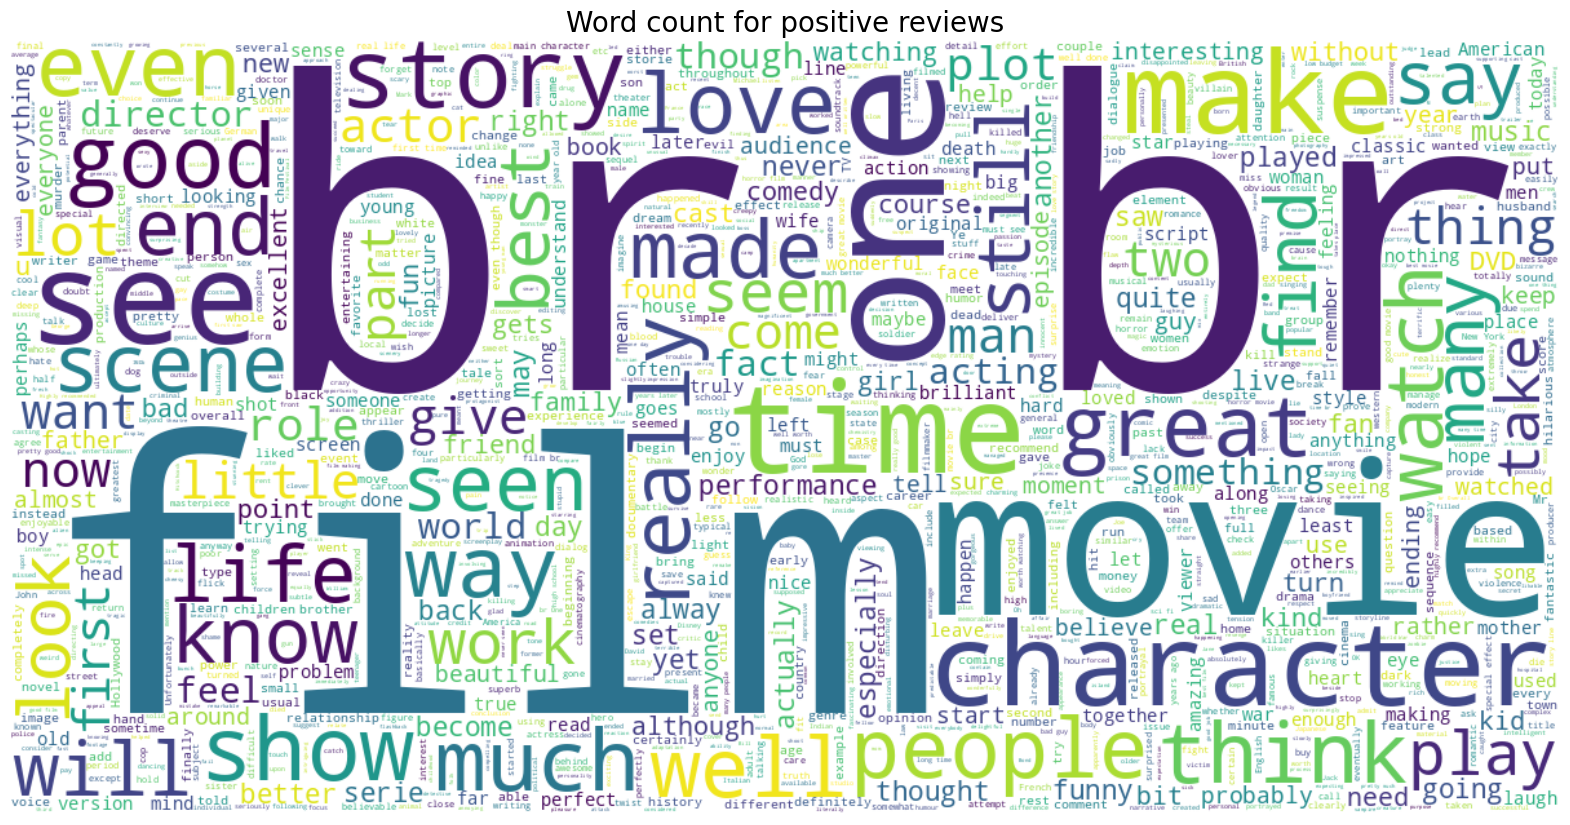

In [ ]:
positive_review = df[df.sentiment == 'Positive']["review"]
positive_review_string = ' '.join(positive_review)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1200,width = 1200, height=600,background_color= "white").generate(positive_review_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.title("Word count for positive reviews",fontsize=20)
plt.show()

Générer un nuage de mots pour les critiques negative. Tout d'abord, il filtre les avis qui ont un sentiment positif et les concatène en une seule variable de chaîne. Ensuite, il crée un nuage de mots à l'aide de la bibliothèque WordCloud

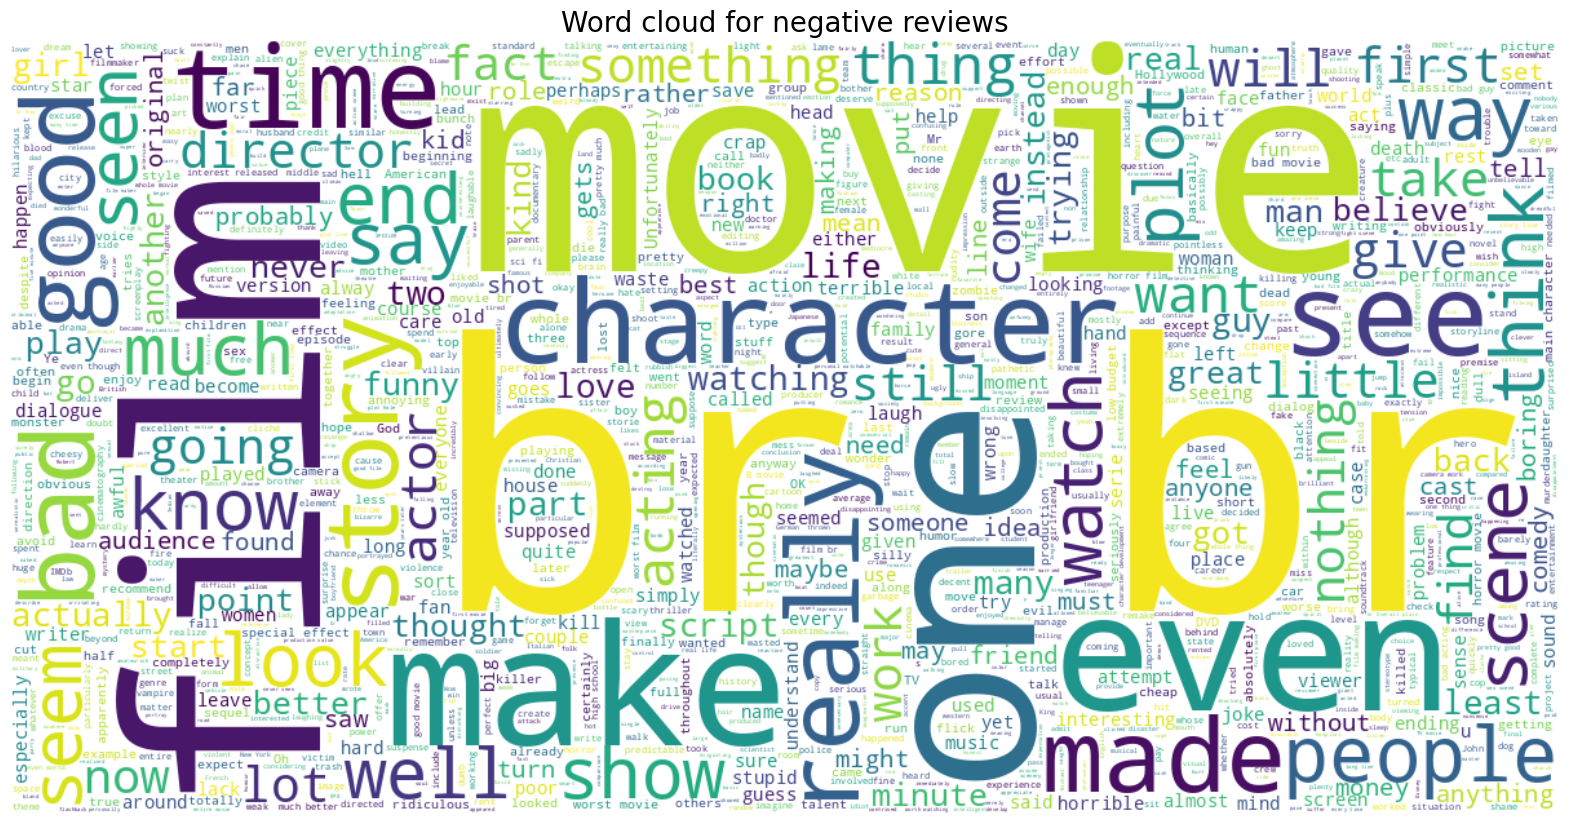

In [ ]:
negative_data = df[df.sentiment == 'Negative']['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

Figure with two subplots, each showing the distribution of the number of characters in positive and negative movie reviews, respectively.

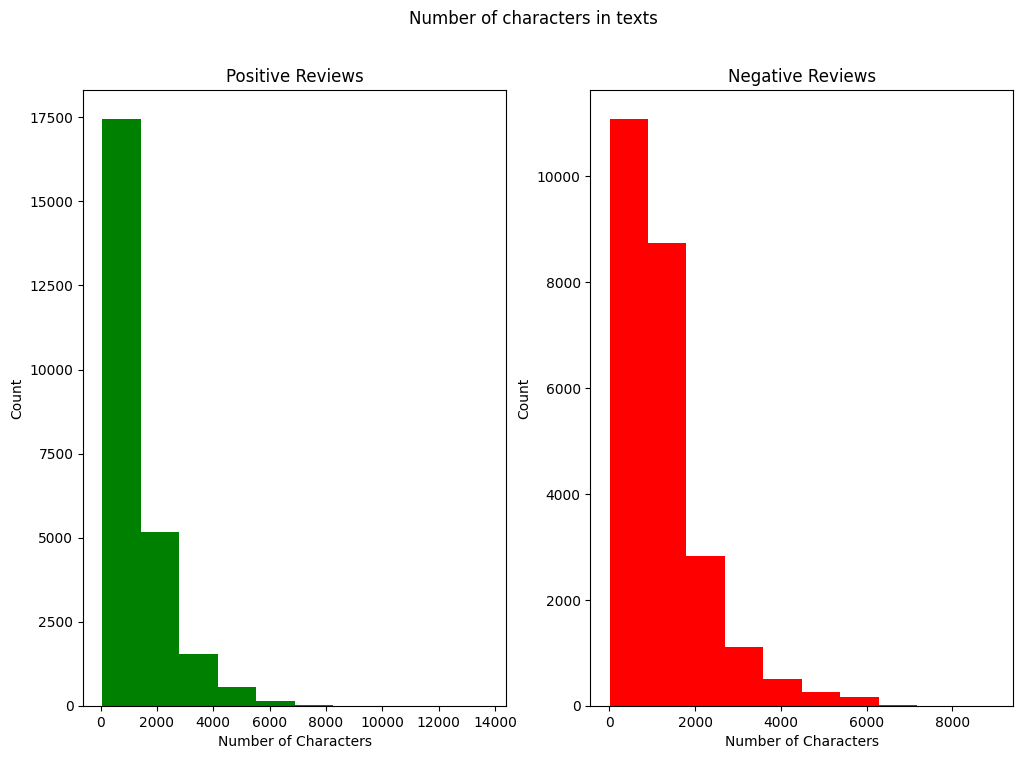

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_review.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

Définit une fonction nommée get_corpus qui prend un ensemble de données et renvoie une liste de tous les mots présents dans l'ensemble de données. Ensuite, il crée un corpus à partir du jeu de données en ajoutant tous les mots à une liste nommée corpus.

Après cela, il compte le nombre d'occurrences de chaque mot dans le corpus à l'aide de la méthode Counter de la bibliothèque de collections, puis extrait les 10 mots les plus courants à l'aide de la méthode most_common. Il trie ensuite la liste par ordre croissant en fonction du nombre de chaque mot à l'aide de la méthode sort_values, et renvoie enfin une trame de données pandas avec deux colonnes : 'words' et 'count_', représentant respectivement les mots les plus courants et leur nombre.

In [ ]:
def get_corpus(data):
    corpus = []
    for i in data:
        for j in i.split():
            corpus.append(j.strip())
    return corpus
corpus = get_corpus(df.review)
count = Counter(corpus)
most_words = count.most_common(10)
most_common = pd.DataFrame(most_words,columns=["words","count_"])
# Sorting 
most_common= most_common.sort_values('count_')
most_common

words  count_
9  this  112814
8  that  125875
7     I  131359
6    in  168733
5    is  201663
4    to  259885
3    of  281590
2   and  299750
1     a  304808
0   the  564450

Vérifier le nombre de valeurs manquantes dans chaque colonne de la dataframe 'df'. La première ligne calcule le nombre total de valeurs manquantes dans chaque colonne et trie les colonnes dans l'ordre décroissant du nombre de valeurs manquantes. La deuxième ligne calcule le pourcentage de valeurs manquantes dans chaque colonne et trie les colonnes dans l'ordre décroissant du pourcentage de valeurs manquantes. La troisième ligne concatène les deux dataframes calculés, 'total_null' et 'percent', le long de l'axe des colonnes avec les noms de colonne 'Total Missing' et 'In Percent'. La trame de données résultante "missing_data" indique le nombre et le pourcentage de valeurs manquantes dans chaque colonne.

In [ ]:
total_null = df.isnull().sum().sort_values(ascending = False)
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)

missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
missing_data

Total Missing  In Percent
review                 0         0.0
sentiment              0         0.0

## 3.4 Nettoyage des données
Effectuer le nettoyage des données sur la colonne 'review' de la dataframe 'df'. Plus précisément, il effectue les opérations suivantes sur chaque élément de la colonne 'review' :

* Suppression des balises HTML à l'aide de l'expression regex.
* Suppression des hashtags à l'aide de l'expression regex.
* Suppression des mentions à l'aide de l'expression regex.
* Suppression d'URL à l'aide d'une expression regex.
* Conversion de toutes les lettres en minuscules.
* Suppression de tous les caractères non alphabétiques (y compris la ponctuation et les chiffres) du texte.

Le texte nettoyé est à nouveau stocké dans la colonne 'review'.

In [ ]:
#Remove HTML
df['review'].replace( { r"<.*?>" : ' ' }, inplace= True, regex = True)

#Remove Hashtags
df['review'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
df['review'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
df['review'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

#to lowercase
df['review']=df['review'].str.lower()

# remove special caracter, ponctuation, numbers
df['review'] = df['review'].apply(lambda x : re.sub('[^a-z]+', ' ', x).strip())

Supprime les mots vides des données textuelles dans la colonne "révision" de la trame de données. La liste des mots vides est obtenue à partir du corpus "mots vides" de la bibliothèque NLTK pour la langue anglaise. Le code segmente chaque avis en mots individuels, vérifie si chaque mot est un mot vide et ne retient que les mots qui ne sont pas des mots vides. Le texte nettoyé est ensuite enregistré dans la colonne "révision" de la trame de données.

In [ ]:
# remove stopwords
stopwords = stopwords.words("english")
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

Fonction appelée "stemming" qui prend un texte en entrée, le segmente à l'aide de word_tokenize, applique le radical Snowball à chaque jeton et renvoie la phrase radicale sous forme de chaîne. La fonction est ensuite appliquée à la colonne "review" du dataframe à l'aide de la méthode "apply", qui remplace chaque review originale par sa version radicale. Ce processus est appelé radical et est utilisé pour réduire les mots fléchis ou dérivés à leur forme de base ou racine, ce qui peut aider dans les tâches d'analyse de texte telles que l'analyse des sentiments.

In [ ]:
# Stemming
snow = SnowballStemmer('english')

def stemming(text):
  stemmed_sentence = []
  # Word Tokenizer
  words = word_tokenize(text)
  for w in words:
      # Apply Stemming
      stemmed_sentence.append(snow.stem(w))
  return " ".join(stemmed_sentence)

df['review'] = df['review'].apply(stemming)

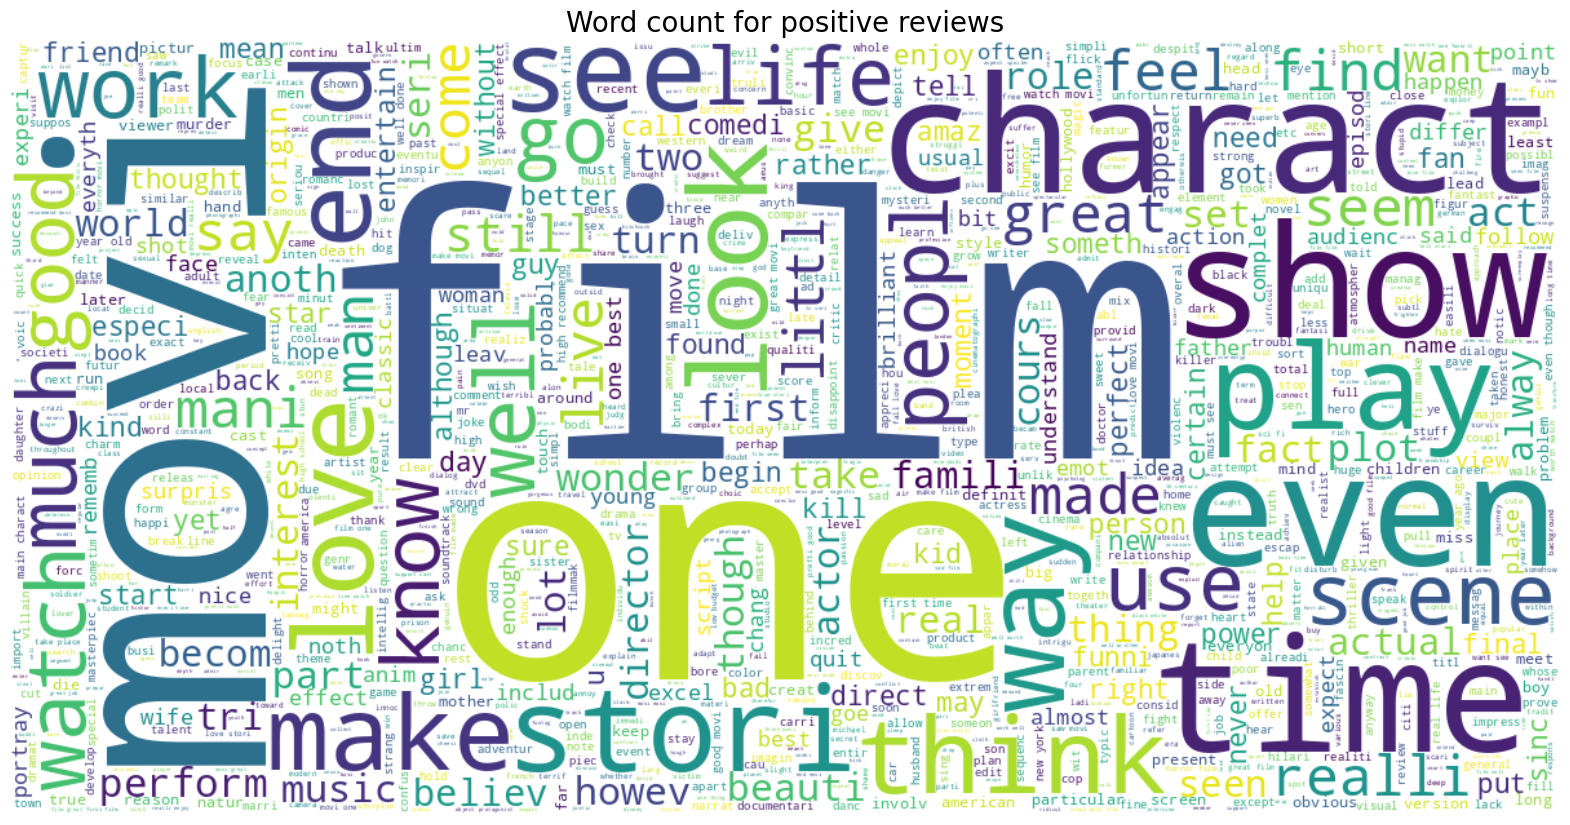

In [ ]:
positive_review = df[df.sentiment == 'Positive']["review"]
positive_review_string = ' '.join(positive_review)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1200,width = 1200, height=600,background_color= "white").generate(positive_review_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.title("Word count for positive reviews",fontsize=20)
plt.show()

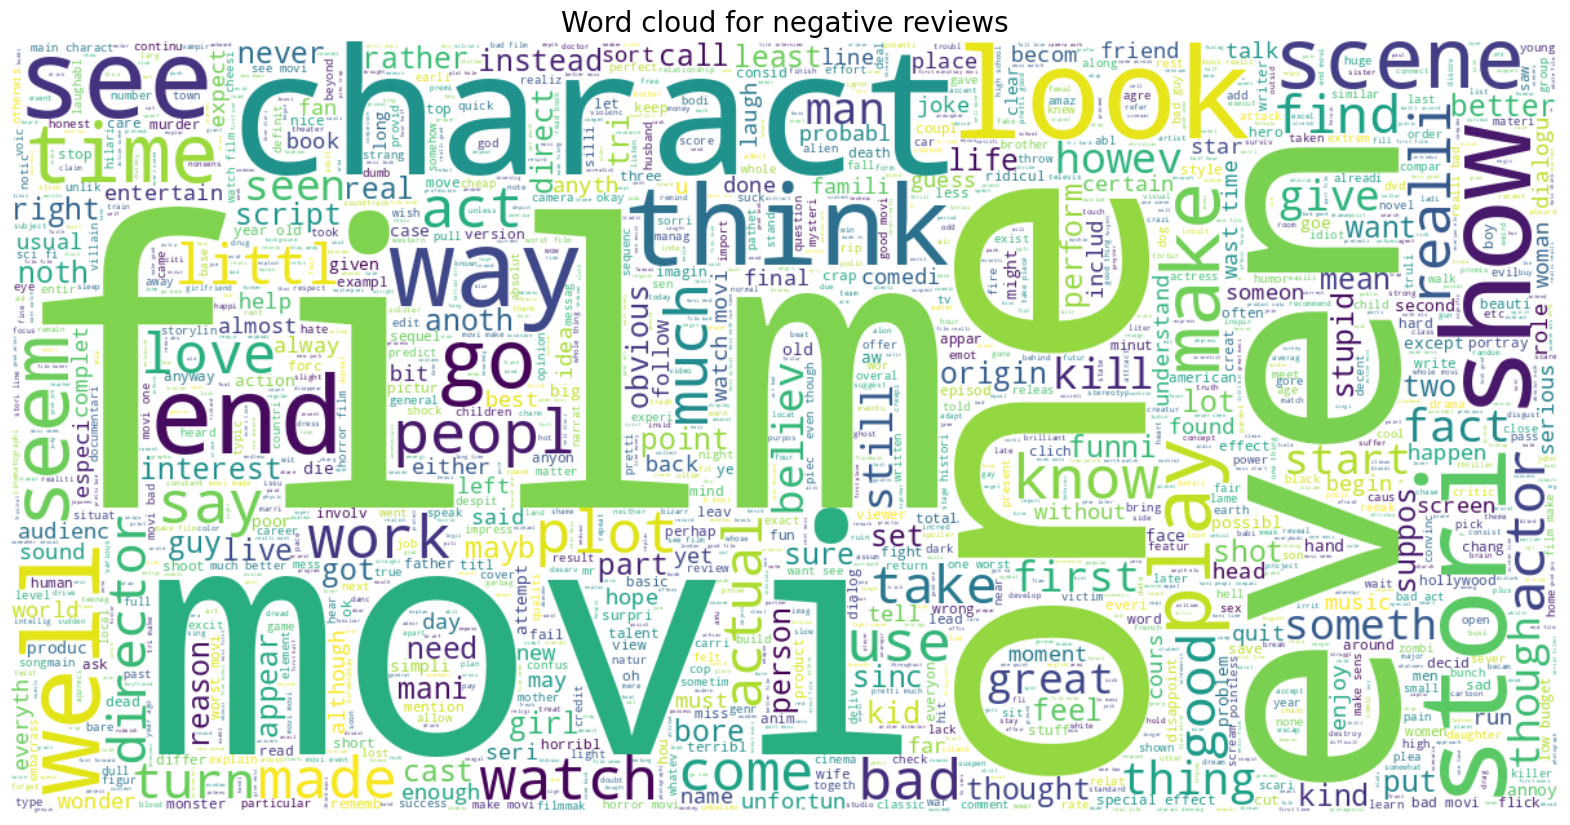

In [ ]:
negative_data = df[df.sentiment == 'Negative']['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

## 3.5 Conception des modèle

Créer deux tableaux, X et y. X est défini sur la colonne 'review' dans le dataframe et y est défini sur la colonne 'sentiment' dans le dataframe. Ces tableaux seront utilisés comme données d'entrée et étiquettes cibles pour le modèle d'apprentissage automatique.

In [ ]:
X = df['review'].values
y = df['sentiment'].values

La classe LabelEncoder de scikit-learn est utilisée pour coder les fonctionnalités cibles catégorielles sous forme d'entiers, qui sont plus faciles à utiliser dans les modèles d'apprentissage automatique. Dans ce cas, nous avons encodé la colonne cible de sentiment qui avait deux valeurs possibles : "Positif" et "Négatif" comme 1 et 0 respectivement. Les valeurs transformées sont stockées dans y.

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(y)

Diviser l'ensemble de données en ensembles d'apprentissage et de test avec un rapport de 75:25. L'ensemble d'apprentissage sera utilisé pour former le modèle, tandis que l'ensemble de test sera utilisé pour évaluer ses performances. X_train et y_train sont l'ensemble d'apprentissage, tandis que X_test et y_test sont l'ensemble de test. Le paramètre test_size détermine le pourcentage des données qui doivent être utilisées pour les tests. random_state est un paramètre facultatif qui spécifie la valeur de départ aléatoire du fractionnement, afin que le même fractionnement puisse être reproduit ultérieurement.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=df['sentiment'])

Initialise un objet Tokenizer à partir du module keras.preprocessing.text et l'adapte à l'ensemble d'apprentissage à l'aide de la méthode fit_on_texts. L'objet Tokenizer est utilisé pour convertir chaque révision de l'ensemble d'apprentissage et de test en séquences d'entiers à l'aide de la méthode texts_to_sequences. La variable max_words est définie sur 10 000, ce qui signifie que seuls les 10 000 mots les plus courants de l'ensemble de données seront pris en compte. Les séquences sont ensuite rembourrées pour avoir la même longueur à l'aide de la fonction pad_sequences du module keras.preprocessing.sequence. La longueur des séquences est déterminée par la variable max_seq_length, qui est définie sur la longueur de la séquence la plus longue de l'ensemble d'apprentissage.

In [ ]:
# Set the maximum number of words to consider in the dataset
max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [ ]:
import pickle
with open('sentiment_analysis_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
folder = mega.find('text_classification')
mega.upload('sentiment_analysis_tokenizer.pickle', folder[0])

{'f': [{'h': 'ZJ0GgKZR',
   't': 0,
   'a': 'PBSYnxA5N4IMxWR32kZbHlMNWSNKb4TU3ZLVjwA9uEz2-qhud49OYOz6G0cMd13f',
   'k': '0KUDtk3uCr4:giTnBe4MEqkxiYJ2SNEX-2U0ao83S7ikHylC-tsZ_c8',
   'p': '5M1T0RIa',
   'ts': 1683624381,
   'u': '0KUDtk3uCr4',
   's': 4685362}]}

### 3.5.1 RNN
Réseau neuronal récurrent (RNN) avec une couche d'intégration, une couche de mémoire longue à court terme (LSTM) et une couche dense. Il a été compilé avec la perte d'entropie croisée binaire et l'optimiseur Adam.

Inclus un arrêt anticipé avec une patience de 3 époques et la possibilité de restaurer les meilleurs poids.

Entraîné le modèle pendant 10 époques sur l'ensemble d'apprentissage avec une taille de lot de 32 et évalué ses performances sur l'ensemble de validation.

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=256, input_length=max_seq_length))
rnn_model.add(LSTM(units=256, dropout=0.2))
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_history = rnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1163/1163 [==============================] - 258s 218ms/step - loss: 0.4411 - accuracy: 0.7986 - val_loss: 0.4105 - val_accuracy: 0.8224
Epoch 2/10
1163/1163 [==============================] - 175s 151ms/step - loss: 0.3754 - accuracy: 0.8353 - val_loss: 0.3070 - val_accuracy: 0.8763
Epoch 3/10
1163/1163 [==============================] - 171s 147ms/step - loss: 0.2160 - accuracy: 0.9143 - val_loss: 0.2571 - val_accuracy: 0.8975
Epoch 4/10
1163/1163 [==============================] - 165s 142ms/step - loss: 0.1573 - accuracy: 0.9405 - val_loss: 0.2535 - val_accuracy: 0.9008
Epoch 5/10
1163/1163 [==============================] - 165s 142ms/step - loss: 0.1185 - accuracy: 0.9574 - val_loss: 0.3072 - val_accuracy: 0.9004
Epoch 6/10
1163/1163 [==============================] - 166s 143ms/step - loss: 0.0884 - accuracy: 0.9694 - val_loss: 0.3471 - val_accuracy: 0.8958
Epoch 7/10
1163/1163 [==============================] - 165s 142ms/step - loss: 0.0639 - accuracy: 0.9784 - val_

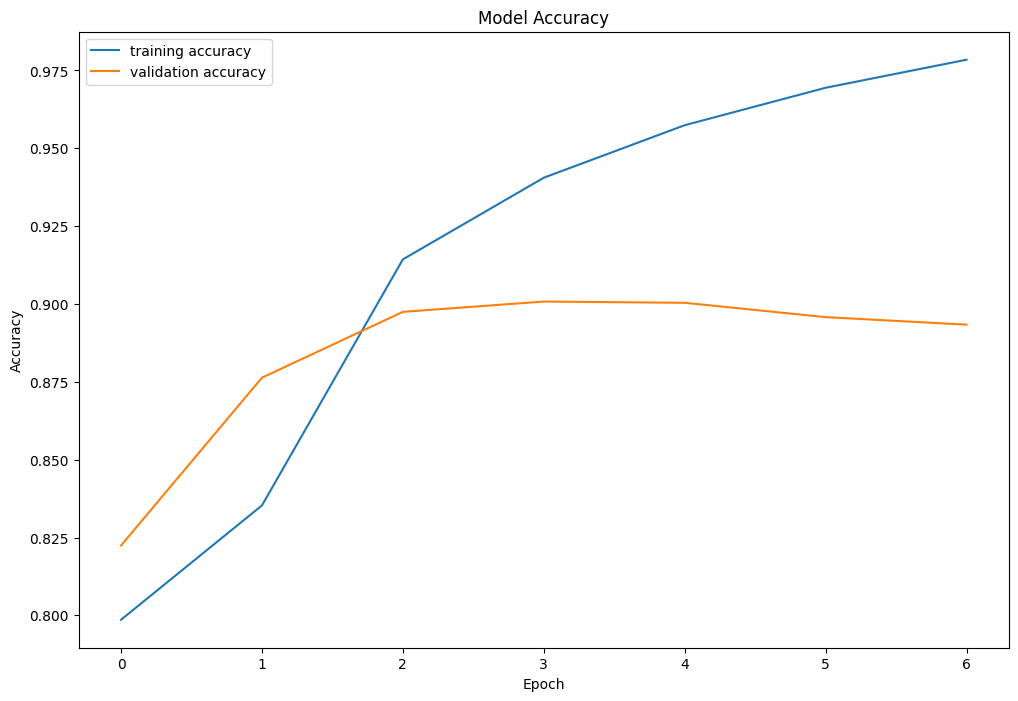

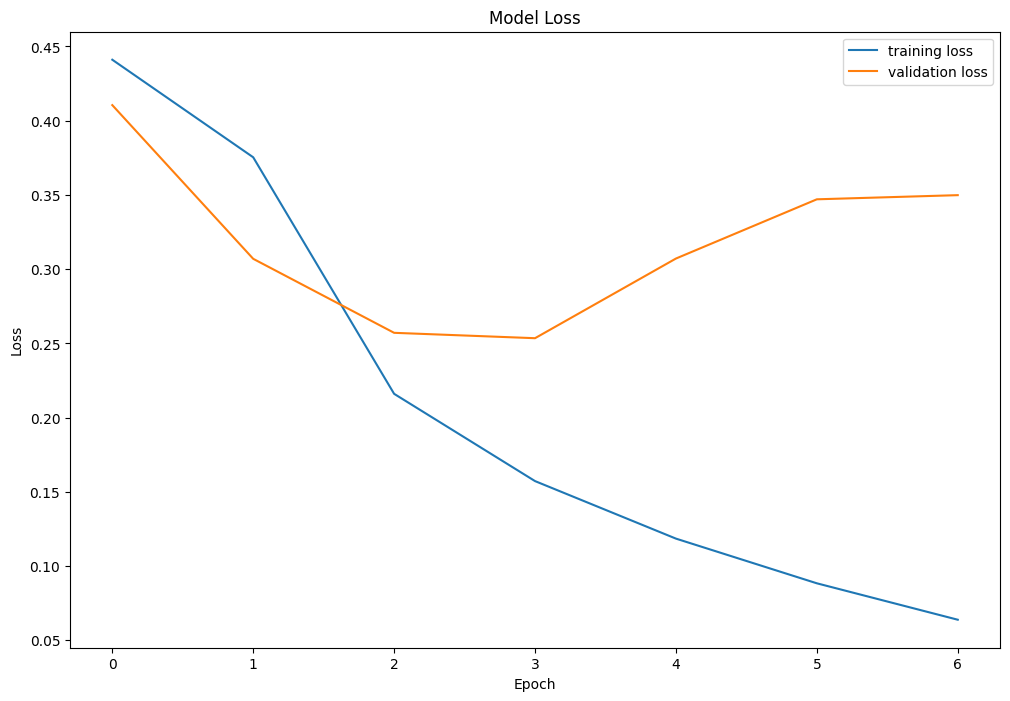

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['accuracy'], label='training accuracy')
ax.plot(rnn_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['loss'], label='training loss')
ax.plot(rnn_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
prediction = rnn_model.predict(X_test_padded)
y_pred = np.round(prediction)
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_pred, y_test)
print('Classification Report:\n', report)

388/388 [==============================] - 17s 44ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      6141
         1.0       0.90      0.90      0.90      6255

    accuracy                           0.90     12396
   macro avg       0.90      0.90      0.90     12396
weighted avg       0.90      0.90      0.90     12396



In [ ]:
rnn_model.save("sentiment_analysis_rnn.h5")

In [ ]:
folder = mega.find('text_classification')
mega.upload('sentiment_analysis_rnn.h5', folder[0])

{'f': [{'h': 'tItBCZQJ',
   't': 0,
   'a': 'BQjyqyGoUbQFbmcjIh1uzHRG07ChCLlihlDiahQxC7wglrXrrN4cTRa4g-TOiNRf',
   'k': '0KUDtk3uCr4:XL6fq4rBK0hsk91wOPFvEqWYchLvwn1mE28kNjq7_m8',
   'p': '5M1T0RIa',
   'ts': 1683624645,
   'u': '0KUDtk3uCr4',
   's': 340614776}]}

### 3.5.2 RNN with Word2Vec
Crée un modèle Word2Vec à partir des données d'apprentissage et l'utilise pour obtenir la matrice d'intégration de mots, qui est ensuite utilisée pour initialiser la couche d'intégration d'un réseau de neurones LSTM. Le modèle LSTM est ensuite compilé et un arrêt précoce est mis en œuvre pour éviter le surajustement pendant l'entraînement.

In [ ]:
# Train Word2Vec model on our corpus
sentences = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences=sentences, vector_size=256, window=5, min_count=1, workers=4)

# Use Word2Vec model to obtain word embedding matrix
embedding_matrix = w2v_model.wv.vectors

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(LSTM(units=256, dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
rnn_w2v_history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1163/1163 [==============================] - 254s 216ms/step - loss: 0.4428 - accuracy: 0.7836 - val_loss: 0.2815 - val_accuracy: 0.8825
Epoch 2/10
1163/1163 [==============================] - 192s 165ms/step - loss: 0.2327 - accuracy: 0.9066 - val_loss: 0.2398 - val_accuracy: 0.9042
Epoch 3/10
1163/1163 [==============================] - 179s 154ms/step - loss: 0.1766 - accuracy: 0.9329 - val_loss: 0.2524 - val_accuracy: 0.9000
Epoch 4/10
1163/1163 [==============================] - 177s 152ms/step - loss: 0.1373 - accuracy: 0.9479 - val_loss: 0.2666 - val_accuracy: 0.9004
Epoch 5/10
1163/1163 [==============================] - 178s 153ms/step - loss: 0.0977 - accuracy: 0.9643 - val_loss: 0.3081 - val_accuracy: 0.8948


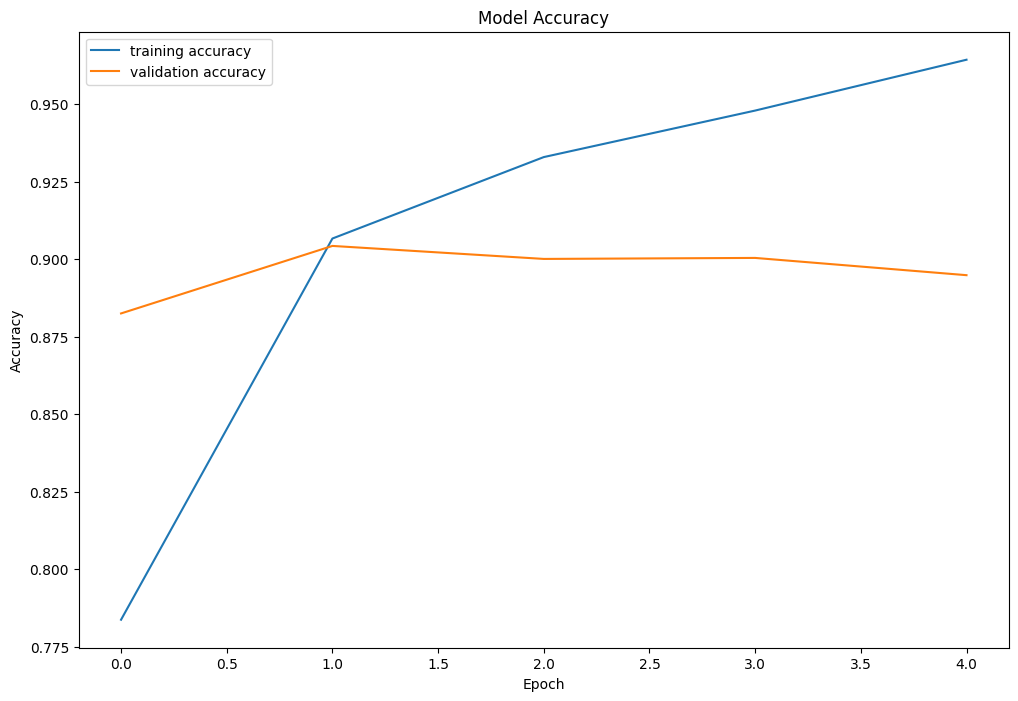

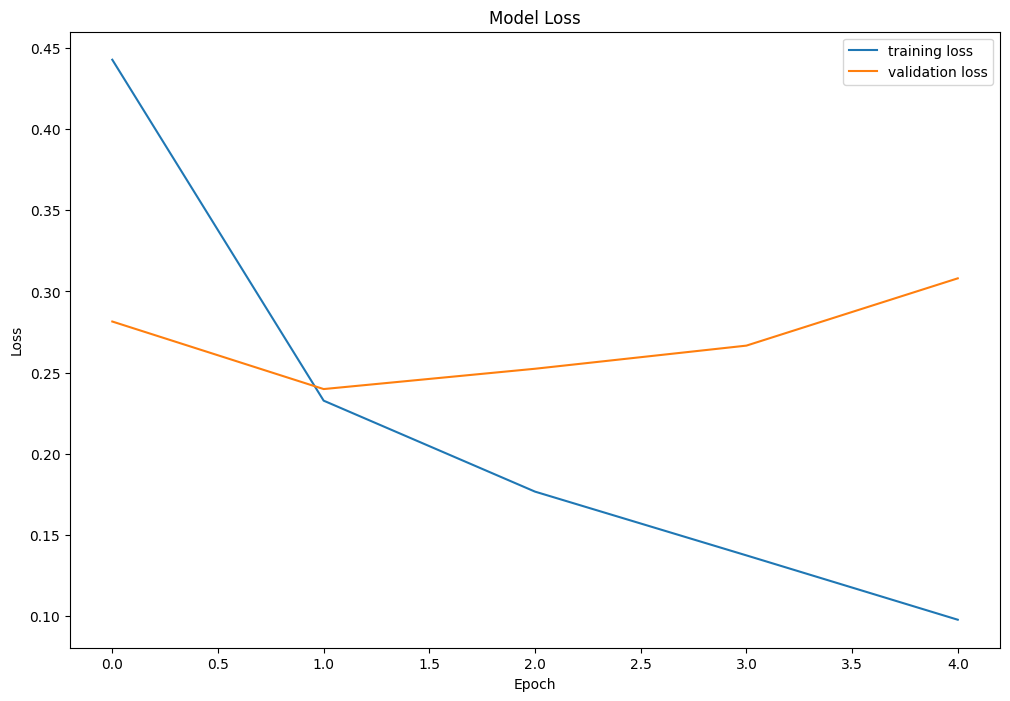

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_w2v_history.history['accuracy'], label='training accuracy')
ax.plot(rnn_w2v_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_w2v_history.history['loss'], label='training loss')
ax.plot(rnn_w2v_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test_padded)
y_pred = np.round(prediction)
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_pred, y_test)
print('Classification Report:\n', report)

388/388 [==============================] - 17s 44ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      6096
         1.0       0.91      0.90      0.91      6300

    accuracy                           0.90     12396
   macro avg       0.90      0.90      0.90     12396
weighted avg       0.90      0.90      0.90     12396



In [ ]:
model.save("sentiment_analysis_rnn_w2v.h5")

In [ ]:
folder = mega.find('text_classification')
mega.upload('sentiment_analysis_rnn_w2v.h5', folder[0])

### 3.5.3 Conv1D
Le modèle comprend une couche d'intégration, une couche convolutive 1D avec 256 filtres et une taille de noyau de 3, une couche d'abandon avec un taux de 0,2, une couche de mise en commun maximale globale et une couche entièrement connectée avec activation sigmoïde pour la classification binaire. Le modèle est compilé avec une perte d'entropie croisée binaire et l'optimiseur Adam, et formé avec un arrêt précoce et une taille de lot de 32. Les données de formation et de validation sont transmises au modèle pendant 10 époques.

In [ ]:
conv_model = Sequential()
conv_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=256, input_length=max_seq_length))
conv_model.add(Conv1D(filters=256, kernel_size=3, padding='valid', activation='relu', strides=1))
conv_model.add(Dropout(0.2))
conv_model.add(GlobalMaxPooling1D())
conv_model.add(Dense(units=1, activation='sigmoid'))
conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
conv_history = conv_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1163/1163 [==============================] - 124s 101ms/step - loss: 0.3195 - accuracy: 0.8593 - val_loss: 0.2524 - val_accuracy: 0.8981
Epoch 2/10
1163/1163 [==============================] - 65s 56ms/step - loss: 0.1814 - accuracy: 0.9292 - val_loss: 0.2385 - val_accuracy: 0.9025
Epoch 3/10
1163/1163 [==============================] - 57s 49ms/step - loss: 0.1005 - accuracy: 0.9658 - val_loss: 0.2599 - val_accuracy: 0.9002
Epoch 4/10
1163/1163 [==============================] - 55s 47ms/step - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.2886 - val_accuracy: 0.9010
Epoch 5/10
1163/1163 [==============================] - 55s 47ms/step - loss: 0.0223 - accuracy: 0.9942 - val_loss: 0.3248 - val_accuracy: 0.9000


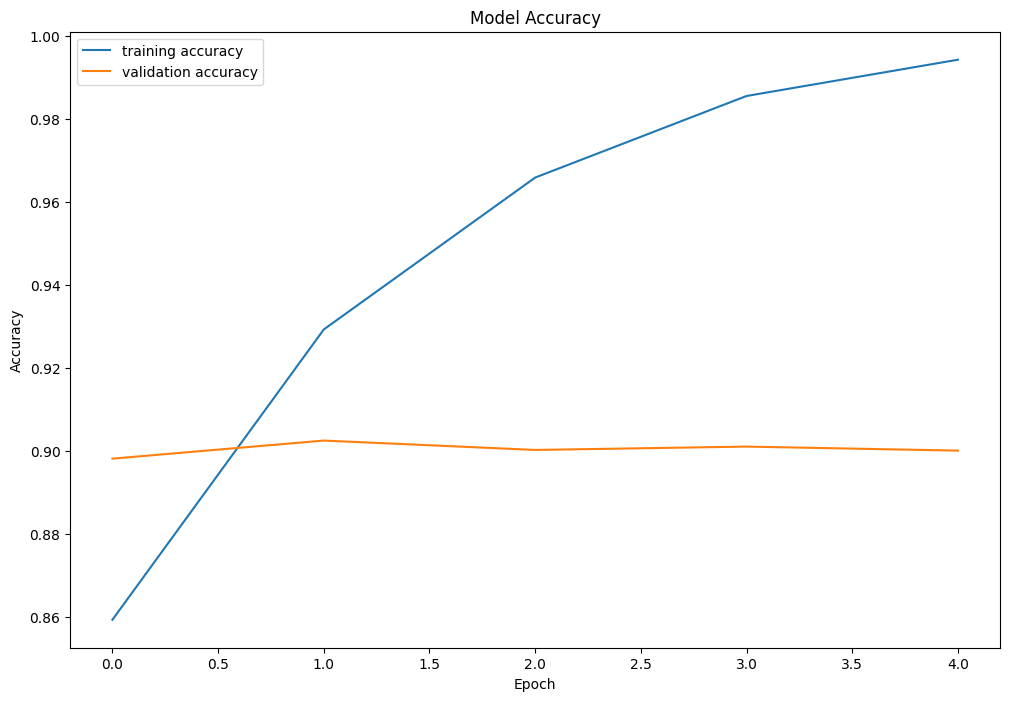

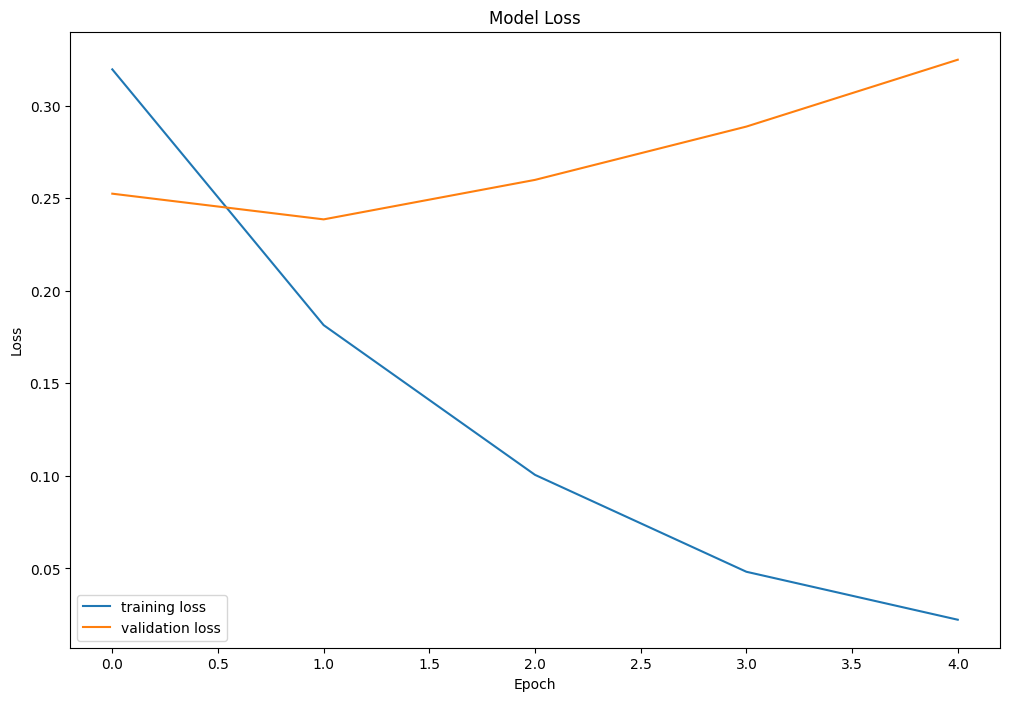

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(conv_history.history['accuracy'], label='training accuracy')
ax.plot(conv_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(conv_history.history['loss'], label='training loss')
ax.plot(conv_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
prediction = conv_model.predict(X_test_padded)
y_pred = np.round(prediction)
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_pred, y_test)
print('Classification Report:\n', report)

388/388 [==============================] - 4s 10ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      6028
         1.0       0.91      0.89      0.90      6368

    accuracy                           0.90     12396
   macro avg       0.90      0.90      0.90     12396
weighted avg       0.90      0.90      0.90     12396



In [ ]:
conv_model.save("sentiment_analysis_conv.h5")

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('text_classification')
mega.upload('sentiment_analysis_conv.h5', folder[0])

{'f': [{'h': 'tN9XyZqJ',
   't': 0,
   'a': 'zLphCrbYhFP_RdA_zWuZh1EyYwCaKmH5_ICaDRDps9EU3F9OZ6VrrUdCsT7qS4yK',
   'k': '0KUDtk3uCr4:pfKrPUvoPAZyIGdz-ZDNGmAYDd9E2NmGZ2vDJLkl4HM',
   'p': '5M1T0RIa',
   'ts': 1683625242,
   'u': '0KUDtk3uCr4',
   's': 336672200}]}

### 3.5.4 TCN
Un modèle TCN (Temporal Convolutional Network) est défini et compilé pour effectuer une classification binaire sur l'ensemble de données de revue de films IMDB. Le modèle TCN se compose d'une couche d'intégration suivie d'une couche TCN avec 256 filtres et une taille de noyau de 3, une couche d'abandon pour éviter le surajustement et une couche dense avec une fonction d'activation sigmoïde pour produire le résultat de la classification binaire. Le modèle est ensuite entraîné à l'aide de l'ensemble d'entraînement et un arrêt précoce est utilisé pour éviter le surajustement. L'ensemble de validation est utilisé pour surveiller les performances du modèle pendant la formation.

In [ ]:
# Define the TCN model
tcn_model = Sequential()
tcn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=256, input_length=max_seq_length ,trainable = False))
tcn_model.add(TCN(nb_filters=256, kernel_size=3, activation='relu'))
tcn_model.add(Dropout(0.2))
tcn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tcn_history = tcn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1163/1163 [==============================] - 457s 386ms/step - loss: 0.5323 - accuracy: 0.7040 - val_loss: 0.5017 - val_accuracy: 0.7744
Epoch 2/10
1163/1163 [==============================] - 445s 382ms/step - loss: 0.3194 - accuracy: 0.8625 - val_loss: 0.3304 - val_accuracy: 0.8529
Epoch 3/10
1163/1163 [==============================] - 475s 408ms/step - loss: 0.2421 - accuracy: 0.9030 - val_loss: 0.3095 - val_accuracy: 0.8736
Epoch 4/10
1163/1163 [==============================] - 474s 407ms/step - loss: 0.1726 - accuracy: 0.9331 - val_loss: 0.5046 - val_accuracy: 0.8210
Epoch 5/10
1163/1163 [==============================] - 474s 408ms/step - loss: 0.1227 - accuracy: 0.9534 - val_loss: 0.3673 - val_accuracy: 0.8719
Epoch 6/10
1163/1163 [==============================] - 474s 408ms/step - loss: 0.0882 - accuracy: 0.9679 - val_loss: 0.4537 - val_accuracy: 0.8683


In [ ]:
prediction = tcn_model.predict(X_test_padded)
y_pred = np.round(prediction)
# Compute the confusion matrix, accuracy, precision, recall, and F1 score
report = classification_report(y_pred, y_test)
print('Classification Report:\n', report)

388/388 [==============================] - 52s 133ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.85      0.88      6676
         1.0       0.83      0.91      0.87      5720

    accuracy                           0.87     12396
   macro avg       0.87      0.88      0.87     12396
weighted avg       0.88      0.87      0.87     12396



In [ ]:
tcn_model.save("sentiment_analysis_tcn.h5")

In [ ]:
mega = Mega()
mega._login_user('models@tonestudio.fr','models@tonestudio.fr')

folder = mega.find('text_classification')
mega.upload('sentiment_analysis_tcn.h5', folder[0])

{'f': [{'h': 'IItyjTaR',
   't': 0,
   'a': '8PSuKEWOWwocT_sja0Ydtx4V8wGAQmaRDtWyuSKo7zB3YZt7KqIj98xLWHG_B3y_',
   'k': '0KUDtk3uCr4:a5dM_ZFJERCgdtWXQKWSVKo5xwxtShhLG4i612ZjOic',
   'p': '5M1T0RIa',
   'ts': 1683628260,
   'u': '0KUDtk3uCr4',
   's': 139884024}]}

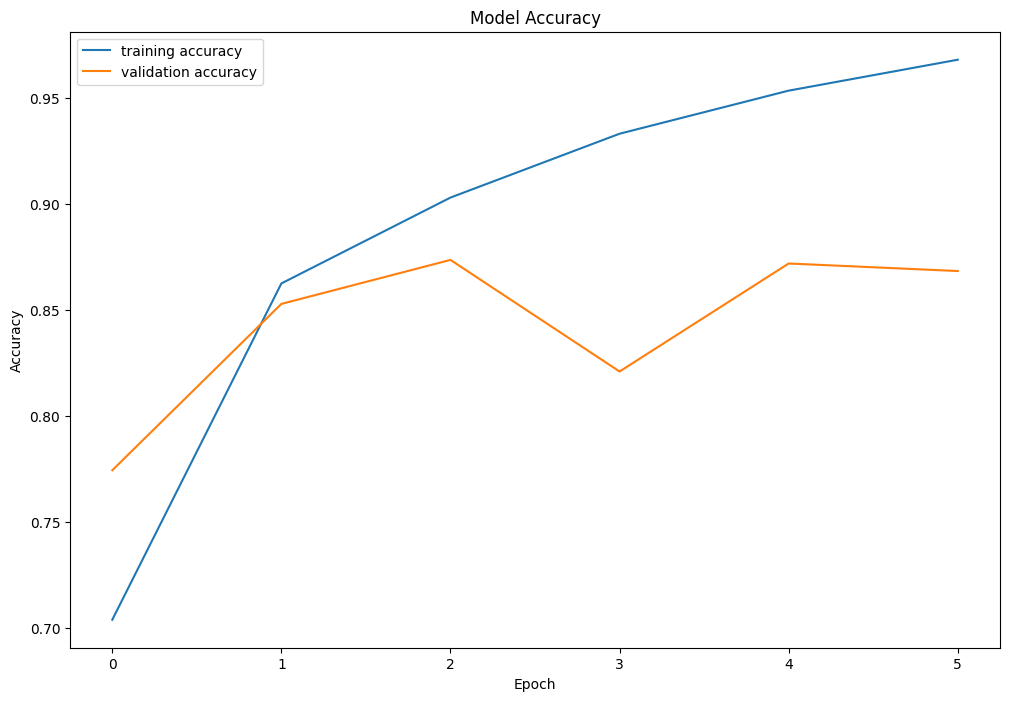

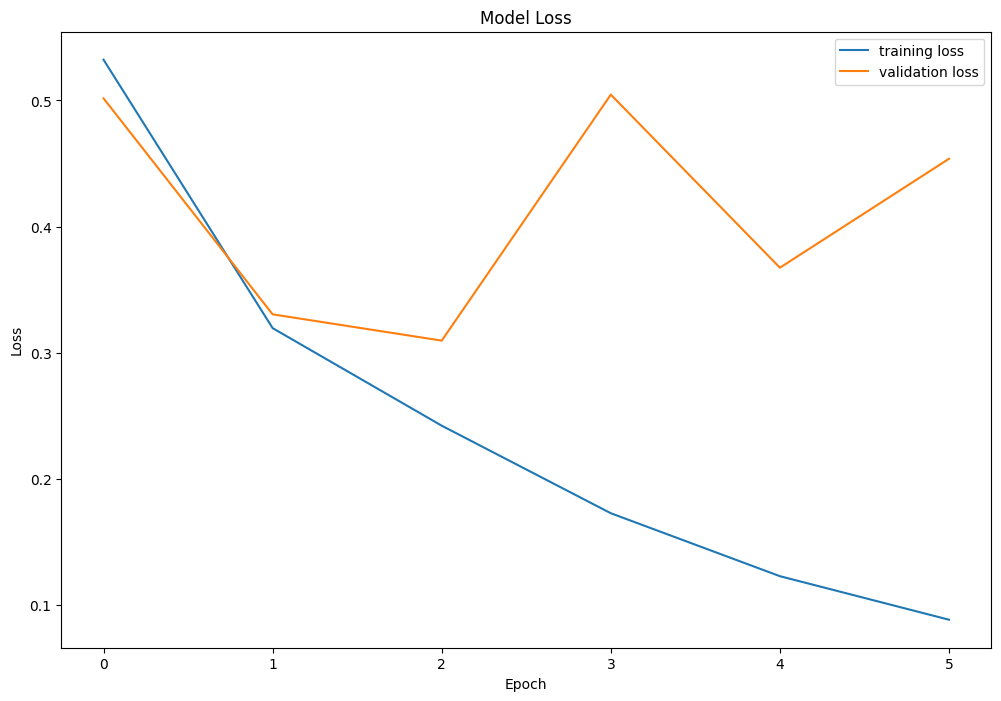

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(tcn_history.history['accuracy'], label='training accuracy')
ax.plot(tcn_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(tcn_history.history['loss'], label='training loss')
ax.plot(tcn_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

### Experiment RNN

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
rnn_model.add(LSTM(units=64, dropout=0.2))
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_history = rnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

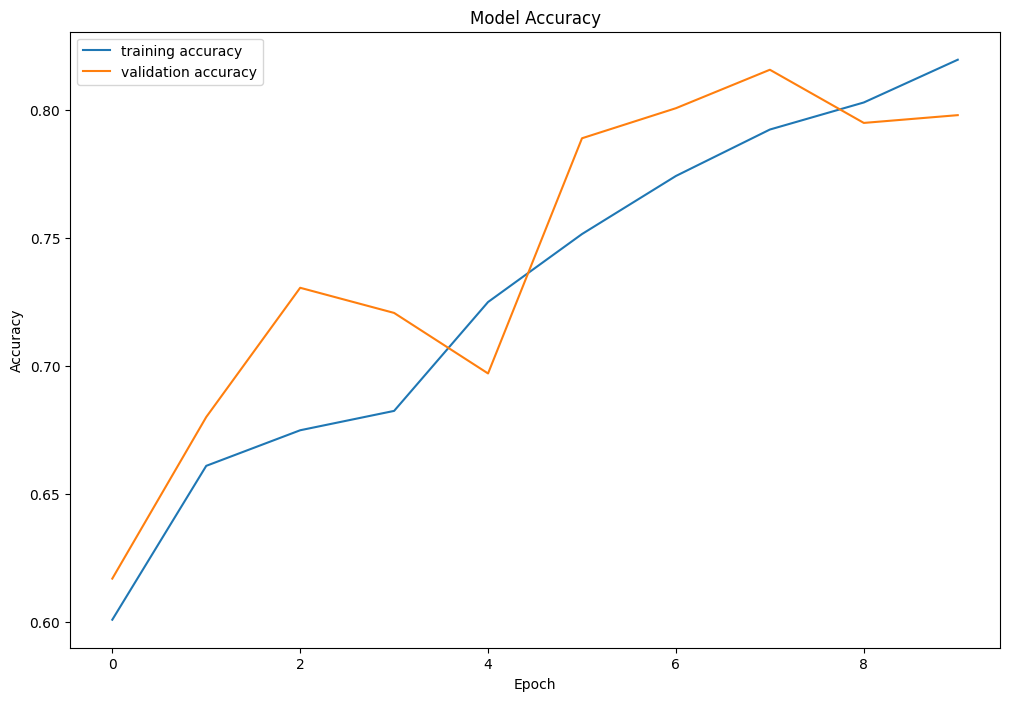

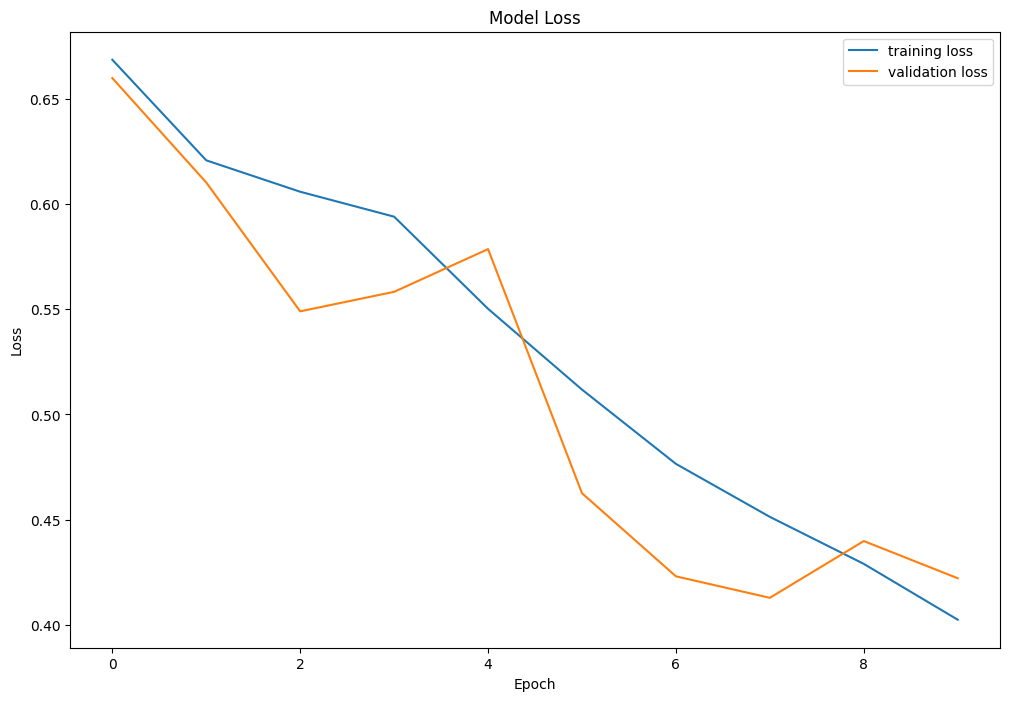

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['accuracy'], label='training accuracy')
ax.plot(rnn_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['loss'], label='training loss')
ax.plot(rnn_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
rnn_model.add(LSTM(units=32, dropout=0.2, return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units=16, dropout=0.2))
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_history = rnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1172/1172 [==============================] - 179s 147ms/step - loss: 0.3426 - accuracy: 0.8533 - val_loss: 0.2760 - val_accuracy: 0.8858
Epoch 2/10
1172/1172 [==============================] - 102s 87ms/step - loss: 0.2227 - accuracy: 0.9145 - val_loss: 0.3085 - val_accuracy: 0.8709
Epoch 3/10
1172/1172 [==============================] - 93s 79ms/step - loss: 0.1809 - accuracy: 0.9319 - val_loss: 0.3098 - val_accuracy: 0.8834
Epoch 4/10
1172/1172 [==============================] - 89s 76ms/step - loss: 0.1380 - accuracy: 0.9503 - val_loss: 0.3377 - val_accuracy: 0.8774


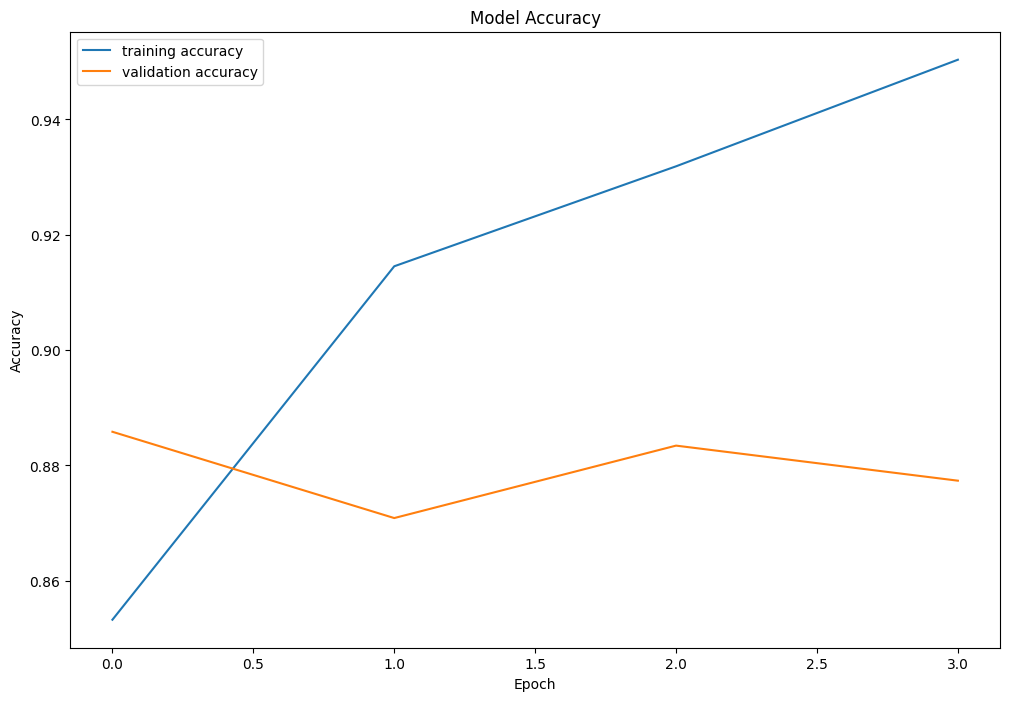

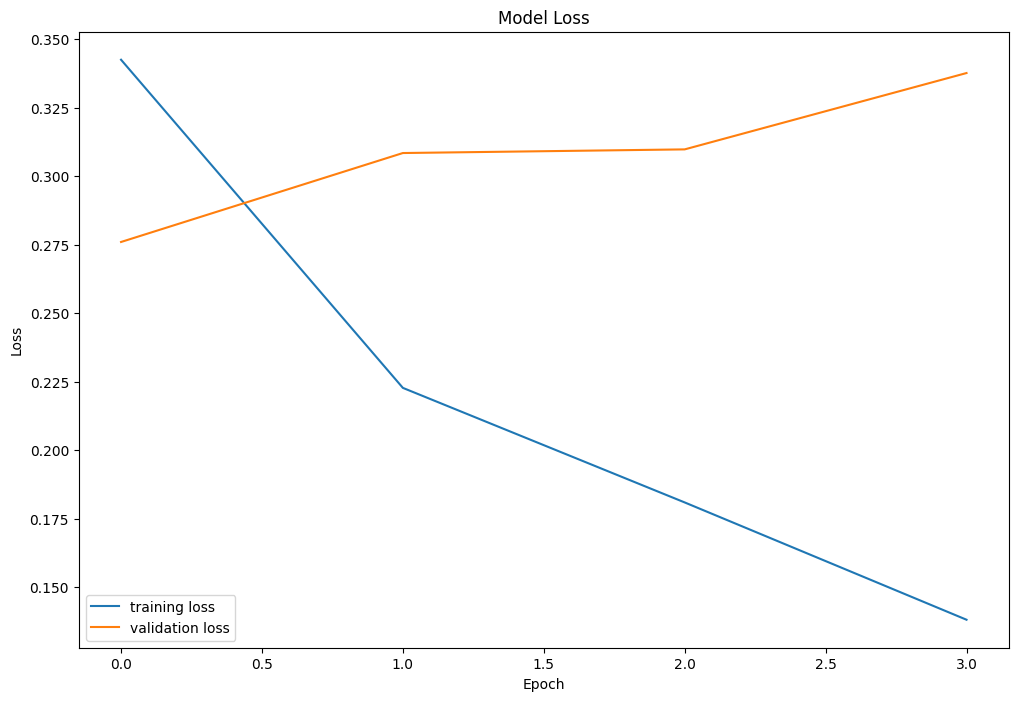

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['accuracy'], label='training accuracy')
ax.plot(rnn_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['loss'], label='training loss')
ax.plot(rnn_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
rnn_model.add(LSTM(units=64, dropout=0.2, kernel_regularizer=l2(0.01)))
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_history = rnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1172/1172 [==============================] - 140s 116ms/step - loss: 0.4558 - accuracy: 0.8272 - val_loss: 0.2902 - val_accuracy: 0.8852
Epoch 2/10
1172/1172 [==============================] - 72s 61ms/step - loss: 0.2596 - accuracy: 0.9033 - val_loss: 0.2790 - val_accuracy: 0.8895
Epoch 3/10
1172/1172 [==============================] - 71s 60ms/step - loss: 0.2236 - accuracy: 0.9193 - val_loss: 0.2899 - val_accuracy: 0.8864
Epoch 4/10
1172/1172 [==============================] - 63s 54ms/step - loss: 0.1965 - accuracy: 0.9312 - val_loss: 0.3032 - val_accuracy: 0.8866
Epoch 5/10
1172/1172 [==============================] - 60s 51ms/step - loss: 0.1760 - accuracy: 0.9391 - val_loss: 0.3308 - val_accuracy: 0.8834


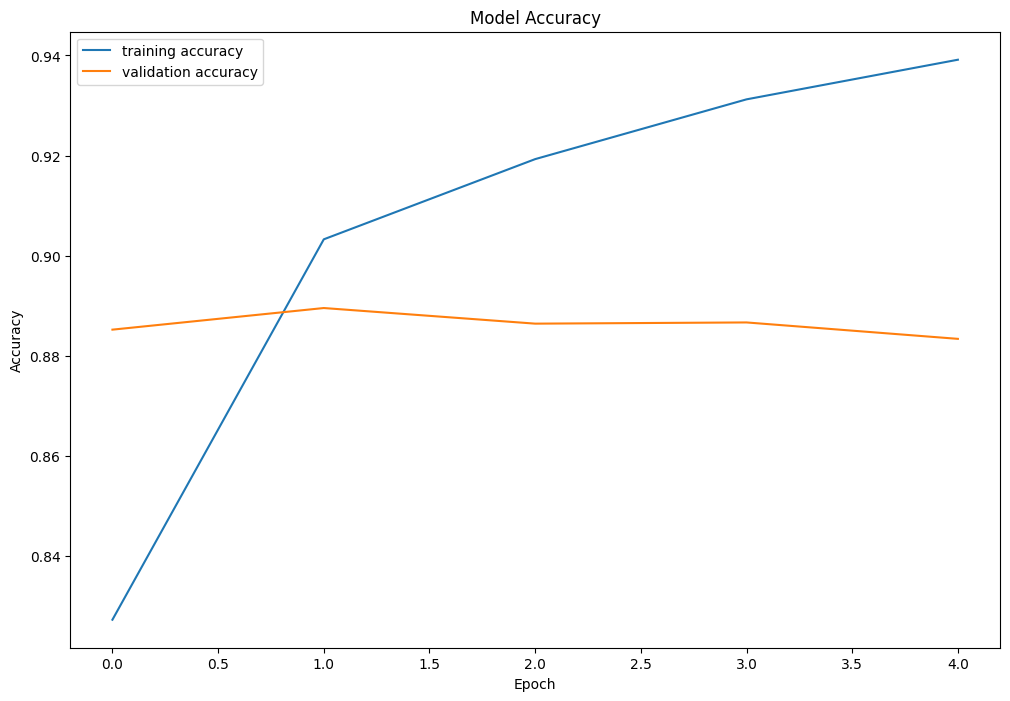

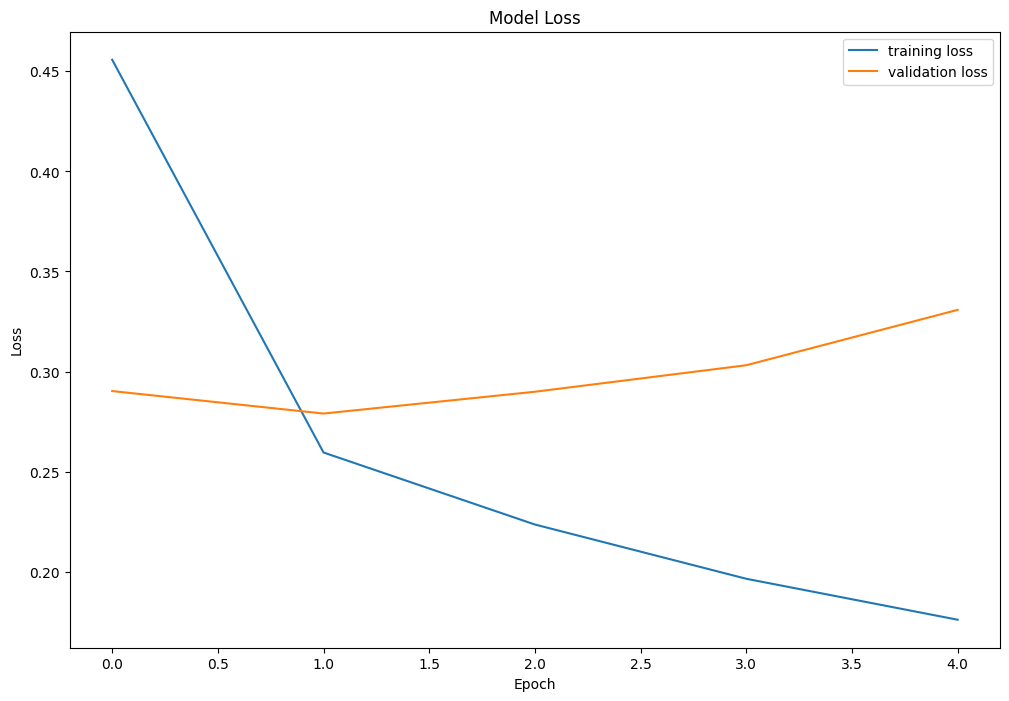

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['accuracy'], label='training accuracy')
ax.plot(rnn_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['loss'], label='training loss')
ax.plot(rnn_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
rnn_model.add(LSTM(units=64, dropout=0.2, kernel_regularizer=l1(0.01)))
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_history = rnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
 599/1172 [==============>...............] - ETA: 11:29 - loss: 2.1923 - accuracy: 0.5231

KeyboardInterrupt: ignored

In [ ]:
# plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['accuracy'], label='training accuracy')
ax.plot(rnn_history.history['val_accuracy'], label='validation accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rnn_history.history['loss'], label='training loss')
ax.plot(rnn_history.history['val_loss'], label='validation loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## 3.6 Comparation des modele

| Model | Accuracy | precision | recall | f1-score |
| :- | -: | :-: | :-: | :-: |
| RNN | 90 | 90 | 90 | 90
| RNN Word2Vec | 90 | 90 | 90| 90
| Conv1D | 90 | 90 | 90 | 90
| TCN | 87 | 87 | 88 | 87

## 3.7 Méthode de prédiction
Pour utiliser que la méthode de prédiction, suivre les étapes suivants :

1. Téléchargez et installez les packages et leurs dépendances. (bloc 3.1)
2. Importation des bibliothèques et modules nécessaires. (bloc 3.2)
3. Exécuter la cellule contient la login MEGA une fois que l'identifiant est remplie. (bloc 3.2)

Si vous n'ête pas conserné par les personnes qui ont eu l'identifiant partager, télecherger les models + tokenizer manuellement et importer sur colab.

`sentiment_analysis_tokenizer.pickle` : https://mega.nz/file/ENdnhBgT#a74HxrLVK99mPb-_Wd9lq0B49s7qMb64meQ4l4l2VJ8
`sentiment_analysis_rnn.h5` : https://mega.nz/file/tBcgkDYC#dtzHJWUTD6z0CgXF-qV4zDclo5HolbOKCLIysc294W4
`sentiment_analysis_rnn_w2v.h5` : https://mega.nz/file/cQU0XYga#kRDDqQouOGGArRdYIE6ICxLI7G10kwh1UyDIP6EJsIc
`sentiment_analysis_conv.h5` : https://mega.nz/file/xE9kTRwT#G76lwf9a22GRRcxljdbuvcrKGA0RMvu34cRaiKZjJ-I
`sentiment_analysis_tcn.h5` : https://mega.nz/file/MEEnSIQS#a_7mscglYUh-Y_dBcGzxrEDlXr4s3oX9B-xAPvasPIQ

In [ ]:
def custom_predict(model_name, text):
  model_name_only = model_name
  model_name_prefix = 'sentiment_analysis_'
  model_names = ['rnn_w2v', 'rnn', 'tcn', 'conv']
  if model_name in model_names:
    model_name = model_name_prefix + model_name + '.h5'
    if not os.path.isfile("sentiment_analysis_tokenizer.pickle"):
      print('Downloadeding tokenizer...')
      file = mega.find('text_classification/sentiment_analysis_tokenizer.pickle')
      mega.download(file)
      print('Tokenizer downloaded.')
    if not os.path.isfile(model_name):
      print('Downloadeding model...')
      file = mega.find('text_classification/'+model_name)
      mega.download(file)
      print('Model downloaded.')
    if model_name_only == 'tcn':
      model = load_model(model_name, custom_objects={"TCN" : TCN})
    else:
      model = load_model(model_name)
    # Tokenize the text
    with open('sentiment_analysis_tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
    text_seq = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_seq, maxlen=2033)
    # Predict the sentiment
    proba = model.predict(text_padded)[0][0]
    if proba >= 0.5:
        sentiment = "positive"
    else:
        sentiment = "negative"
    return {
        "text" : text, 
        "sentiment" : sentiment, 
        "probability" : proba, 
        "percentage" : {
            "positive" : "{}%".format(int(round(proba * 100))),
            "negative" : "{}%".format(int(round((1-proba) * 100)))
        }}
  else:
    print('model name not found, possible name are : ', model_names)

In [ ]:
model_names = ['rnn_w2v', 'rnn', 'tcn', 'conv']

In [ ]:
custom_predict(model_names[1], "It all leads back to where we once started off as all great trilogies have indicated from the past. But GOTG surpasses expectations with what is nothing short of phenomenal performances by the cast and truly well written and does not shy away from what could only be understood from what requires a sense of maturity to understand. Rockets back story alone is on occasion dark and incredibly sad it had me in tears at a few instances during the film. Honestly I did not expect this, James Gunn yet again provides an absolutely beautiful piece of cinematography and I have to say I really hope in the future they dive back into the story of the colony . With Adam warlock finally in the MCU it's most likely there will be some cameos. But it does deliver in the traditional guardians humor but this film is meant about more for the mature audience of marvel. Trust me this is a great film.")

Downloadeding tokenizer...
Tokenizer downloaded.
Downloadeding model...
Model downloaded.
1/1 [==============================] - 5s 5s/step


{'text': "It all leads back to where we once started off as all great trilogies have indicated from the past. But GOTG surpasses expectations with what is nothing short of phenomenal performances by the cast and truly well written and does not shy away from what could only be understood from what requires a sense of maturity to understand. Rockets back story alone is on occasion dark and incredibly sad it had me in tears at a few instances during the film. Honestly I did not expect this, James Gunn yet again provides an absolutely beautiful piece of cinematography and I have to say I really hope in the future they dive back into the story of the colony . With Adam warlock finally in the MCU it's most likely there will be some cameos. But it does deliver in the traditional guardians humor but this film is meant about more for the mature audience of marvel. Trust me this is a great film.",
 'sentiment': 'positive',
 'probability': 0.9950472,
 'percentage': {'positive': '100%', 'negative'

In [ ]:
custom_predict(model_names[1], "I don't know what movie people leaving the high reviews saw but it wasn't Guardians. This installment takes everything that worked in previous Guardian movies and throws it away. Terrible story line, poorly timed bad (and not 'good bad') jokes and don't even get me started on Adam Warlock. His character was so lame. Some of the costume choices are beyond bad. The movie as a whole was just bad. I don't want to give anything away but in short it was bad.")

1/1 [==============================] - 0s 381ms/step


{'text': "I don't know what movie people leaving the high reviews saw but it wasn't Guardians. This installment takes everything that worked in previous Guardian movies and throws it away. Terrible story line, poorly timed bad (and not 'good bad') jokes and don't even get me started on Adam Warlock. His character was so lame. Some of the costume choices are beyond bad. The movie as a whole was just bad. I don't want to give anything away but in short it was bad.",
 'sentiment': 'negative',
 'probability': 0.007771983,
 'percentage': {'positive': '1%', 'negative': '99%'}}